# Testing of multiple parameters

### Module code 

In [1]:
# Following changes more than code 9
# added center of reward landscape directly to the environment as parameter
# direct adding of seed to the environment
# changing the spread of the main gaussian 
# changing the number of distractors
'''Works as a module for the main script'''

import os
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap

# save plots in a folder
save_dir = "plots"

# 2D reward landscapesno
def gaussian(coordinates, height, mean, spread):
    ''' Returns a scalar value for given coordinates in a 2D gaussian distribution'''
    x, y = coordinates[0], coordinates[1]
    return height * np.exp(-((x-mean[0])**2 + (y-mean[1])**2)/(2*spread**2))

def new_sigmoid(x, m=0.0, a=0.0):
    """ Returns an output between -1 and 1 """
    return (2 / (1 + np.exp(-1*(x-a)*m))) - 1

def sigmoid(x, m =0.0 , a=0.0 ):
    """ Returns an output between 0 and 1 """
    return 1 / (1 + np.exp(-1*(x-a)*m))


''' Needs tuning to escape local max '''
# RANDOM_SEED = np.random.randint(0, 1000)
# print(f'Random seed is {RANDOM_SEED}')
# np.random.seed(RANDOM_SEED)
# CENTER = np.random.uniform(-0.9, 0.9, 2)
# layer sizes
HVC_SIZE = 100
BG_SIZE = 50
RA_SIZE = 100 
MC_SIZE = 2
N_RA_CLUSTERS = MC_SIZE
N_BG_CLUSTERS = 2

# sigmoid layer parameters
BG_sig_slope = 2.5  # uniform output 
BG_sig_mid = 0
RA_sig_slope = 15 # most steep such that MC output is not skewed
RA_sig_mid = 0
# Sigmoid on MC is removed
# MC_sig_slope = 1 # 5 if lesser -> more difficult to climb the hill, assymptotes before 
# MC_sig_mid = 0

# parameters
reward_window = 10
input = np.zeros(HVC_SIZE)
input[1] = 1
BG_noise = 0.1

# Run paraneters

N_DISTRACTORS = 10
LEARING_RATE_RL = 0.1
LEARNING_RATE_HL = 1.6e-5 # small increase compared to CODE_8
TRIALS = 1000
DAYS = 61 # 60 days of learning and 1 day of testing

# modes
ANNEALING = True
ANNEALING_SLOPE = 4 
ANNEALING_MID = 2
HEBBIAN_LEARNING = True
balance_factor = 2
BG_influence = True

# Model
class NN:
    def __init__(self, hvc_size, bg_size, ra_size, mc_size):
        self.W_hvc_bg = np.random.uniform(-1, 1, (hvc_size, bg_size)) # changing from -1 to 1 
        self.W_hvc_ra = np.zeros((hvc_size, ra_size)) # connections start from 0 and then increase
        self.W_bg_ra = np.random.uniform(0, 1, (bg_size, ra_size)) # const from 0 to 1
        self.W_ra_mc = np.random.uniform(0, 1, (ra_size, mc_size)) # const from 0 to 1
        # channel from ra to mc
        for i in range(N_RA_CLUSTERS):
            segPath = np.diag(np.ones(N_RA_CLUSTERS, int))[i]
            self.W_ra_mc[i*ra_size//N_RA_CLUSTERS : (i+1)*ra_size//N_RA_CLUSTERS] *= segPath
        # channel from bg to ra such that motor cortex components are independent of each other
        for i in range(N_BG_CLUSTERS):
            segPath = np.diag(np.ones(N_BG_CLUSTERS, int))[i]
            self.W_bg_ra[i*bg_size//N_BG_CLUSTERS : (i+1)*bg_size//N_BG_CLUSTERS] *= [j for j in segPath for r in range(RA_SIZE//N_BG_CLUSTERS)]

        self.hvc_size = hvc_size
        self.bg_size = bg_size
        self.ra_size = ra_size
        self.mc_size = mc_size  
        self.ra_cluster_size = ra_size // N_RA_CLUSTERS
        self.bg_cluster_size = bg_size // N_BG_CLUSTERS
        self.bg_influence = BG_influence
            
    def forward(self, hvc_array):
        self.hvc = hvc_array
        # count number of 1 in hvc, divide bg by that number
        num_ones = np.count_nonzero(hvc_array == 1)
        self.bg = new_sigmoid(np.dot(hvc_array/num_ones, self.W_hvc_bg) + np.random.normal(0, BG_noise, self.bg_size), m = BG_sig_slope, a = BG_sig_mid)
        self.ra = new_sigmoid(np.dot(self.bg, self.W_bg_ra/np.sum(self.W_bg_ra, axis=0)) * balance_factor * self.bg_influence + np.dot(hvc_array/num_ones, self.W_hvc_ra)* HEBBIAN_LEARNING, m = RA_sig_slope, a = RA_sig_mid) 
        ''' even after BG cut off, output should remain still the same'''
        # self.mc = new_sigmoid(np.dot(self.ra, self.W_ra_mc/np.sum(self.W_ra_mc, axis=0)), m = MC_sig_slope, a = MC_sig_mid)
        # self.bg = np.dot(hvc_array/num_ones, self.W_hvc_bg)  #outputs to +-0.98
        # self.ra = np.dot(self.bg, self.W_bg_ra/np.sum(self.W_bg_ra, axis=0)) * balance_factor  + np.dot(hvc_array/num_ones, self.W_hvc_ra)* HEBBIAN_LEARNING #outputs to +-0.40
        self.mc = np.dot(self.ra, self.W_ra_mc/np.sum(self.W_ra_mc, axis=0)) # outputs to +-0.50
        return self.mc, self.ra, self.bg

class Environment:
    def __init__(self, hvc_size, bg_size, ra_size, mc_size, center, seed):
        self.hvc_size = hvc_size
        self.bg_size = bg_size
        self.ra_size = ra_size
        self.mc_size = mc_size
        self.center = center
        self.seed = seed
        self.model = NN(hvc_size, bg_size, ra_size, mc_size)
        self.heights = np.random.uniform(0.2, 0.7, N_DISTRACTORS)
        self.means = np.random.uniform(-1, 1, (N_DISTRACTORS, 2))
        self.spreads = np.random.uniform(0.1, 0.6, N_DISTRACTORS)
        self.rewards = []
        self.actions = []
        self.hvc_bg_array = []
        self.bg_out = []
        self.hvc_ra_array = []
        self.ra_out = []
        self.dw_day_array = []
        self.pot_array = []
        
    def get_reward(self, coordinates):
        reward_scape = gaussian(coordinates, 1, self.center, 0.3)
        if N_DISTRACTORS == 0:
            return reward_scape
        hills = []
        hills.append(reward_scape)
        for i in range(N_DISTRACTORS):
            height = self.heights[i]
            mean = self.means[i]
            spread = self.spreads[i]
            hills.append(gaussian(coordinates, height, mean, spread))
        return np.maximum.reduce(hills)
    
    def run(self, iterations, learning_rate, learning_rate_hl, input_hvc, annealing = False):
        self.annealing = annealing
        for day in tqdm(range(DAYS)):
            dw_day = 0
            if day >= 60:
                self.model.bg_influence = False
            for iter in range(iterations):
                # reward and baseline
                action, ra, bg = self.model.forward(input_hvc)

                reward = self.get_reward(action)
                self.rewards.append(reward)
                self.actions.append(action)
                if iter < 1:
                    reward_baseline = 0
                else:
                    reward_baseline = np.mean(self.rewards[-reward_window:-1])
                # Updates 
                # RL update
                dw_hvc_bg = learning_rate*(reward - reward_baseline)*input_hvc.reshape(self.hvc_size,1)*self.model.bg * self.model.bg_influence # RL update
                self.model.W_hvc_bg += dw_hvc_bg
                # HL update
                dw_hvc_ra = learning_rate_hl*input_hvc.reshape(self.hvc_size,1)*self.model.ra*HEBBIAN_LEARNING # lr is supposed to be much smaller here
                self.model.W_hvc_ra += dw_hvc_ra
                # bound weights between +-1
                self.model.W_hvc_bg = np.clip(self.model.W_hvc_bg, -1, 1)
                self.model.W_hvc_ra = np.clip(self.model.W_hvc_ra, -1, 1)
                dw_day += np.mean(np.abs(dw_hvc_bg))
                
                self.hvc_bg_array.append(self.model.W_hvc_bg[1,1])
                self.bg_out.append(bg[1])
                self.hvc_ra_array.append(self.model.W_hvc_ra[1,1])
                self.ra_out.append(ra[1])
            # if day % 6 == 0:   
                # tqdm.write(f'Day: {day}, Action: {action}, Reward: {reward}, Reward Baseline: {reward_baseline}')    
            # Annealing
            if annealing:
                ''' input daily sum, output scaling factor for potentiation'''
                p = dw_day*100
                self.dw_day_array.append(p)
                p = 1* sigmoid(1*p, m = ANNEALING_SLOPE, a = ANNEALING_MID)
                potentiation_factor = np.zeros((self.hvc_size))
                self.pot_array.append(1-p)
                potentiation_factor[1] = 1-p 
                night_noise = np.random.uniform(-1, 1, self.bg_size) # make it lognormal
                dw_night = LEARING_RATE_RL*potentiation_factor.reshape(self.hvc_size,1)*night_noise*10*self.model.bg_influence
                self.model.W_hvc_bg += dw_night
                self.model.W_hvc_bg = (self.model.W_hvc_bg + 1) % 2 -1 # bound between -1 and 1 in cyclical manner
            
                
    def plot_trajectory(self):
        fig, axs = plt.subplots(figsize=(10, 9))
        # generate grid 
        x, y = np.linspace(-1, 1, 50), np.linspace(-1, 1, 50)
        X, Y = np.meshgrid(x, y)
        Z = self.get_reward([X, Y])
        
        # Plot contour
        cmap = LinearSegmentedColormap.from_list('white_to_green', ['white', 'green'])
        contour = axs.contourf(X, Y, Z, levels=10, cmap=cmap)
        fig.colorbar(contour, ax=axs, label='Reward')
        
        # plot trajectory
        x_traj, y_traj = zip(*self.actions)
        axs.plot(x_traj[::10], y_traj[::10], 'r', label='Agent Trajectory', alpha = 0.5, linewidth = 0.5) # Plot every 20th point for efficiency
        axs.scatter(x_traj[0], y_traj[0], s=20, c='b', label='Starting Point')  # Plot first point as red circle
        axs.scatter(x_traj[-5:], y_traj[-5:], s=20, c='r', marker='x', label='Ending Point') # type: ignore
        axs.scatter(CENTER[0], CENTER[1], s=20, c='y', marker='x', label='target')  # type: ignore
        # labels
        axs.set_title('Contour plot of reward function')
        axs.set_xlabel('x')
        axs.set_ylabel('y')
        axs.legend()
        plt.tight_layout()
        plt.show()
        
    def plot_results(self):
        fig, axs = plt.subplots(6, 1, figsize=(10, 15))
        axs[0].plot(self.rewards, '.', markersize=1, linestyle='None')
        axs[0].hlines(0.7, 0, len(self.rewards), colors='r', linestyles='dashed')
        axs[0].set_ylim(0, 1)
        axs[0].set_ylabel('Reward')
        axs[1].plot(self.hvc_bg_array)
        axs[1].set_ylim(-1, 1)
        axs[1].set_ylabel('HVC BG weights')
        axs[2].plot(self.bg_out,'.', markersize=0.5, linestyle='None')
        axs[2].set_ylim(-1, 1)
        axs[2].set_ylabel('BG output')
        axs[3].plot(self.hvc_ra_array)
        axs[3].set_ylim(-1, 1)
        axs[3].set_ylabel('HVC RA weights')
        axs[4].plot(self.actions)
        axs[4].plot(self.center[0]*np.ones(TRIALS*DAYS))
        axs[4].plot(self.center[1]*np.ones(TRIALS*DAYS))
        axs[4].legend(['x target', 'y target'])
        axs[4].set_ylabel('Motor Output')
        axs[4].set_ylim(-1, 1)
        axs[5].plot(self.ra_out)
        axs[5].set_ylim(-1, 1)
        axs[5].set_ylabel('RA activity')
        fig.suptitle('Results', fontsize=20)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    
    def plot_dw_day(self):
        if ANNEALING:
            # Expand dw_day_array and pot_array to match the size of rewards
            expanded_dw_day_array = np.repeat(self.dw_day_array, len(self.rewards) // len(self.dw_day_array))
            expanded_pot_array = np.repeat(self.pot_array, len(self.rewards) // len(self.pot_array))
            plt.title('Annealing')
            plt.plot(expanded_dw_day_array, markersize=1, label='dW_day')
            plt.plot(expanded_pot_array, markersize=1, label='Potentiation factor')
            plt.plot(self.rewards, '.', markersize=1, label='Reward')
            plt.xlabel('Days')
            plt.ylabel('dW_day')
            plt.legend()
            plt.show()
        
    def save_trajectory(self):
        fig, axs = plt.subplots(figsize=(10, 9))
        # generate grid 
        x, y = np.linspace(-1, 1, 50), np.linspace(-1, 1, 50)
        X, Y = np.meshgrid(x, y)
        Z = self.get_reward([X, Y])
        
        # Plot contour
        cmap = LinearSegmentedColormap.from_list('white_to_green', ['white', 'green'])
        contour = axs.contourf(X, Y, Z, levels=10, cmap=cmap)
        fig.colorbar(contour, ax=axs, label='Reward')
        
        # plot trajectory
        x_traj, y_traj = zip(*self.actions)
        axs.plot(x_traj[::10], y_traj[::10], 'r', label='Agent Trajectory', alpha = 0.5, linewidth = 0.5) # Plot every 20th point for efficiency
        axs.scatter(x_traj[0], y_traj[0], s=20, c='b', label='Starting Point')  # Plot first point as red circle
        axs.scatter(x_traj[-5:], y_traj[-5:], s=20, c='r', marker='x', label='Ending Point') # type: ignore
        axs.scatter(self.center[0], self.center[1], s=20, c='y', marker='x', label='target')  # type: ignore
        # labels
        axs.set_title('Contour plot of reward function')
        axs.set_xlabel('x')
        axs.set_ylabel('y')
        axs.legend()
        plt.tight_layout()
        # Create the "plots" directory if it doesn't exist
        os.makedirs(save_dir, exist_ok = True)
        # Clear previous plots (optional):
        # for filename in os.listdir(save_dir):
        #     if filename.startswith("trajectory") and filename.endswith(".png") or filename.endswith(".jpg"):
        #         os.remove(os.path.join(save_dir, filename))
        # Save the plot
        plt.savefig(os.path.join(save_dir, f"trajectory_{self.seed}_{self.annealing}.png"))
        plt.close()  # Close the plot to avoid memory leaks
        
    def save_results(self):
        fig, axs = plt.subplots(6, 1, figsize=(10, 15))
        axs[0].plot(self.rewards, '.', markersize=1, linestyle='None')
        axs[0].hlines(0.7, 0, len(self.rewards), colors='r', linestyles='dashed')
        axs[0].set_ylim(0, 1)
        axs[0].set_ylabel('Reward')
        axs[1].plot(self.hvc_bg_array)
        axs[1].set_ylim(-1, 1)
        axs[1].set_ylabel('HVC BG weights')
        axs[2].plot(self.bg_out,'.', markersize=0.5, linestyle='None')
        axs[2].set_ylim(-1, 1)
        axs[2].set_ylabel('BG output')
        axs[3].plot(self.hvc_ra_array)
        axs[3].set_ylim(-1, 1)
        axs[3].set_ylabel('HVC RA weights')
        axs[4].plot(self.actions)
        axs[4].plot(self.center[0]*np.ones(TRIALS*DAYS))
        axs[4].plot(self.center[1]*np.ones(TRIALS*DAYS))
        axs[4].legend(['x target', 'y target'])
        axs[4].set_ylabel('Motor Output')
        axs[4].set_ylim(-1, 1)
        axs[5].plot(self.ra_out)
        axs[5].set_ylim(-1, 1)
        axs[5].set_ylabel('RA activity')
        fig.suptitle('Results', fontsize=20)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        # Create the "plots" directory if it doesn't exist
        os.makedirs(save_dir, exist_ok = True)
        # Clear previous plots (optional):
        # for filename in os.listdir(save_dir):
        #     if filename.startswith("results") and filename.endswith(".png") or filename.endswith(".jpg"):
        #         os.remove(os.path.join(save_dir, filename))
        # Save the plot
        plt.savefig(os.path.join(save_dir, f"results_{self.seed}_{self.annealing}.png"))
        plt.close()  # Close the plot to avoid memory leaks
        
    
    def save_dw_day(self):
        if ANNEALING:
            # Expand dw_day_array and pot_array to match the size of rewards
            expanded_dw_day_array = np.repeat(self.dw_day_array, len(self.rewards) // len(self.dw_day_array))
            expanded_pot_array = np.repeat(self.pot_array, len(self.rewards) // len(self.pot_array))
            plt.title('Annealing')
            plt.plot(expanded_dw_day_array, markersize=1, label='dW_day')
            plt.plot(expanded_pot_array, markersize=1, label='Potentiation factor')
            plt.plot(self.rewards, '.', markersize=1, label='Reward', alpha = 0.1)
            plt.xlabel('Days')
            plt.ylabel('dW_day')
            plt.legend()
            # Create the "plots" directory if it doesn't exist
            os.makedirs(save_dir, exist_ok = True)
            # Clear previous plots (optional):
            # for filename in os.listdir(save_dir):
            #     if filename.startswith("dw") and filename.endswith(".png") or filename.endswith(".jpg"):
            #         os.remove(os.path.join(save_dir, filename))  
            # Save the plot
            plt.savefig(os.path.join(save_dir, f"dw_{self.seed}_{self.annealing}.png"))
            plt.close()  # Close the plot to avoid memory leaks


def build_and_run(seed, annealing, plot):
    tqdm.write(f" Random seed is {seed}")
    np.random.seed(seed)
    center = np.random.uniform(-0.9, 0.9, 2)
    env = Environment(HVC_SIZE, BG_SIZE, RA_SIZE, MC_SIZE, center, seed)
    env.run(TRIALS, LEARING_RATE_RL, LEARNING_RATE_HL, input, annealing)
    if plot:
        env.save_trajectory()
        env.save_results()
        if annealing:
            env.save_dw_day()
    return np.mean(env.rewards[-100:])

Testing and plotting code below

Seeds:  [ 60  71 194 259 323 373 389 436 466 491]


  0%|          | 0/10 [00:00<?, ?it/s]

 Random seed is 60


 10%|█         | 1/10 [00:37<05:41, 38.00s/it]

 Random seed is 71


 20%|██        | 2/10 [01:16<05:06, 38.37s/it]

 Random seed is 194


 30%|███       | 3/10 [01:56<04:33, 39.03s/it]

 Random seed is 259


 40%|████      | 4/10 [02:35<03:54, 39.16s/it]

 Random seed is 323


 50%|█████     | 5/10 [03:16<03:19, 39.86s/it]

 Random seed is 373


 60%|██████    | 6/10 [03:57<02:39, 39.96s/it]

 Random seed is 389


 70%|███████   | 7/10 [04:37<01:59, 39.98s/it]

 Random seed is 436


 80%|████████  | 8/10 [05:17<01:20, 40.07s/it]

 Random seed is 466


 90%|█████████ | 9/10 [05:56<00:39, 39.63s/it]

 Random seed is 491


100%|██████████| 10/10 [06:40<00:00, 40.10s/it]


Non annealing = [0.3350054540569661, 0.35187441595420926, 0.6679855511143029, 0.9871524965712075, 0.5126017957645042, 0.40939467693166554, 0.21104996304454604, 0.9904431871441733, 0.9910971375185036, 0.6443683103020013]


  0%|          | 0/10 [00:00<?, ?it/s]

 Random seed is 60


 10%|█         | 1/10 [00:43<06:27, 43.06s/it]

 Random seed is 71


 20%|██        | 2/10 [01:21<05:24, 40.56s/it]

 Random seed is 194


 30%|███       | 3/10 [01:58<04:31, 38.85s/it]

 Random seed is 259


 40%|████      | 4/10 [02:38<03:54, 39.16s/it]

 Random seed is 323


 50%|█████     | 5/10 [03:16<03:14, 38.87s/it]

 Random seed is 373


 60%|██████    | 6/10 [03:53<02:32, 38.24s/it]

 Random seed is 389


 70%|███████   | 7/10 [04:34<01:57, 39.20s/it]

 Random seed is 436


 80%|████████  | 8/10 [05:17<01:20, 40.27s/it]

 Random seed is 466


 90%|█████████ | 9/10 [05:56<00:39, 39.81s/it]

 Random seed is 491


100%|██████████| 10/10 [06:35<00:00, 39.53s/it]


RA_sig_slope = 18, LEARNING_RATE_HL = 1.6e-05
Annealing 1 = [0.7191901571333836, 0.9454387457578567, 0.8246753356710144, 0.7574804563140861, 0.3202320633322466, 0.9224288735205008, 0.33869428564673576, 0.813772215317113, 0.9254366224832887, 0.9670980747000368]


  0%|          | 0/10 [00:00<?, ?it/s]

 Random seed is 60


 10%|█         | 1/10 [00:38<05:48, 38.73s/it]

 Random seed is 71


 20%|██        | 2/10 [01:18<05:13, 39.20s/it]

 Random seed is 194


 30%|███       | 3/10 [01:58<04:36, 39.56s/it]

 Random seed is 259


 40%|████      | 4/10 [02:36<03:55, 39.18s/it]

 Random seed is 323


 50%|█████     | 5/10 [03:19<03:22, 40.42s/it]

 Random seed is 373


 60%|██████    | 6/10 [04:00<02:41, 40.46s/it]

 Random seed is 389


 70%|███████   | 7/10 [04:41<02:02, 40.81s/it]

 Random seed is 436


 80%|████████  | 8/10 [05:22<01:21, 40.85s/it]

 Random seed is 466


 90%|█████████ | 9/10 [06:01<00:40, 40.20s/it]

 Random seed is 491


100%|██████████| 10/10 [06:42<00:00, 40.21s/it]


RA_sig_slope = 15, LEARNING_RATE_HL = 1.6e-05
Annealing 2 = [0.1359295599300473, 0.9845415533563029, 0.934505489831487, 0.8019233776697808, 0.44817174255195397, 0.9969459262174142, 0.433393626008911, 0.44325890823511893, 0.8820316784616711, 0.9194882326829104]


  0%|          | 0/10 [00:00<?, ?it/s]

 Random seed is 60


 10%|█         | 1/10 [00:40<06:04, 40.52s/it]

 Random seed is 71


 20%|██        | 2/10 [01:19<05:15, 39.48s/it]

 Random seed is 194


 30%|███       | 3/10 [02:04<04:54, 42.03s/it]

 Random seed is 259


 40%|████      | 4/10 [02:48<04:17, 42.90s/it]

 Random seed is 323


 50%|█████     | 5/10 [03:34<03:40, 44.09s/it]

 Random seed is 373


 60%|██████    | 6/10 [04:17<02:54, 43.58s/it]

 Random seed is 389


 70%|███████   | 7/10 [04:55<02:05, 41.78s/it]

 Random seed is 436


 80%|████████  | 8/10 [05:33<01:21, 40.61s/it]

 Random seed is 466


 90%|█████████ | 9/10 [06:15<00:40, 40.93s/it]

 Random seed is 491


100%|██████████| 10/10 [07:01<00:00, 42.14s/it]


RA_sig_slope = 18, LEARNING_RATE_HL = 2e-05
Annealing 3 = [0.9960518295021804, 0.9517194803720435, 0.8369526822079458, 0.9612692350503518, 0.43098295870564757, 0.9505096835378817, 0.5263578296063127, 0.9834031671915756, 0.8753820485064219, 0.996940436783981]


  0%|          | 0/10 [00:00<?, ?it/s]

 Random seed is 60


 10%|█         | 1/10 [00:42<06:26, 42.97s/it]

 Random seed is 71


 20%|██        | 2/10 [01:25<05:43, 43.00s/it]

 Random seed is 194


 30%|███       | 3/10 [02:11<05:08, 44.02s/it]

 Random seed is 259


 40%|████      | 4/10 [02:55<04:24, 44.03s/it]

 Random seed is 323


 50%|█████     | 5/10 [03:39<03:41, 44.27s/it]

 Random seed is 373


 60%|██████    | 6/10 [04:24<02:57, 44.35s/it]

 Random seed is 389


 70%|███████   | 7/10 [05:09<02:13, 44.66s/it]

 Random seed is 436


 80%|████████  | 8/10 [05:56<01:30, 45.45s/it]

 Random seed is 466


 90%|█████████ | 9/10 [06:42<00:45, 45.60s/it]

 Random seed is 491


100%|██████████| 10/10 [07:23<00:00, 44.36s/it]


RA_sig_slope = 15, LEARNING_RATE_HL = 1.6e-05
Annealing 4 = [0.1359295599300473, 0.9845415533563029, 0.934505489831487, 0.8019233776697808, 0.44817174255195397, 0.9969459262174142, 0.433393626008911, 0.44325890823511893, 0.8820316784616711, 0.9194882326829104]


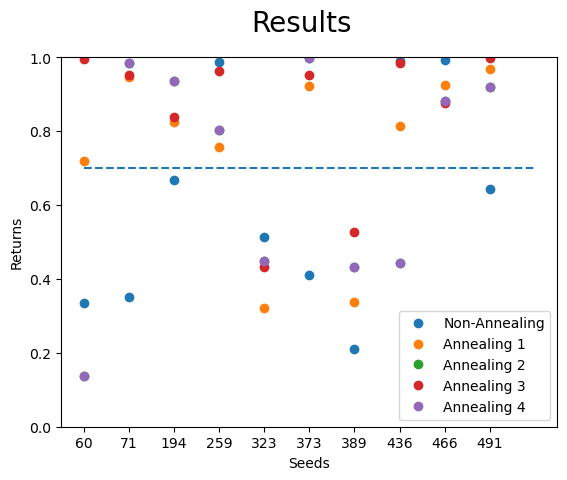

In [2]:
import numpy as np
import sys
import os 
import matplotlib.pyplot as plt
# from module import *
from tqdm import tqdm

save_dir = "C:/Users/Dell\OneDrive%-%Indian%Institute%of%Science\Projects\Bordeaux\Bordeaux_codes/plots"
TEST_NOS = 10
seeds = np.random.randint(0, 500, TEST_NOS)
seeds = np.sort(seeds)
# seeds = [233, 275, 290, 311, 402]

# Redirect stdout to a file
# original_stdout = sys.stdout  # Save a reference to the original standard output
# output_file_path = os.path.join(save_dir, "output.txt")
# with open(output_file_path, 'w') as f:
#     sys.stdout = f  # Change the standard output to the file we created.

print("Seeds: ", seeds)

non_annealing_returns = []
annealing_1 = []
annealing_2 = []
annealing_3 = []
annealing_4 = []

# for filename in os.listdir(save_dir):
#     if filename.endswith(".png") or filename.endswith(".jpg"):
#         os.remove(os.path.join(save_dir, filename))

for i in tqdm(range(TEST_NOS)):
    seed = seeds[i]
    returns = build_and_run(seed, False, True)
    non_annealing_returns.append(returns)
print(f"Non annealing = {non_annealing_returns}")

# annealing 1
RA_sig_slope = 18
LEARNING_RATE_HL = 1.6e-5
for i in tqdm(range(TEST_NOS)):
    seed = seeds[i]
    returns = build_and_run(seed, True, True)
    annealing_1.append(returns)
print(f"RA_sig_slope = {RA_sig_slope}, LEARNING_RATE_HL = {LEARNING_RATE_HL}")
print(f"Annealing 1 = {annealing_1}")

# annealing 2
RA_sig_slope = 15
LEARNING_RATE_HL = 1.6e-5
for i in tqdm(range(TEST_NOS)):
    seed = seeds[i]
    returns = build_and_run(seed, True, True)
    annealing_2.append(returns)
print(f"RA_sig_slope = {RA_sig_slope}, LEARNING_RATE_HL = {LEARNING_RATE_HL}")
print(f"Annealing 2 = {annealing_2}")

# annealing 3
RA_sig_slope = 18
LEARNING_RATE_HL = 2e-5
for i in tqdm(range(TEST_NOS)):
    seed = seeds[i]
    returns = build_and_run(seed, True, True)
    annealing_3.append(returns)
print(f"RA_sig_slope = {RA_sig_slope}, LEARNING_RATE_HL = {LEARNING_RATE_HL}")
print(f"Annealing 3 = {annealing_3}")

# annealing 4
RA_sig_slope = 15
LEARNING_RATE_HL = 1.6e-5
for i in tqdm(range(TEST_NOS)):
    seed = seeds[i]
    returns = build_and_run(seed, True, True)
    annealing_4.append(returns)
print(f"RA_sig_slope = {RA_sig_slope}, LEARNING_RATE_HL = {LEARNING_RATE_HL}")
print(f"Annealing 4 = {annealing_4}")


# Plotting is done outside the file writing block to not capture plot generation messages
fig, ax = plt.subplots(1,1)
ax.plot(non_annealing_returns, label='Non-Annealing', linewidth=0, marker='o')
ax.plot(annealing_1, label='Annealing 1', linewidth=0, marker='o')
ax.plot(annealing_2, label='Annealing 2', linewidth=0, marker='o')
ax.plot(annealing_3, label='Annealing 3', linewidth=0, marker='o')
ax.plot(annealing_4, label='Annealing 4', linewidth=0, marker='o')
ax.set_ylim(0, 1)
plt.xticks(np.arange(0, TEST_NOS, step=1), labels=seeds)
ax.legend()
ax.set_xlabel('Seeds')
ax.set_ylabel('Returns')
plt.hlines(0.7, 0, TEST_NOS, linestyles='dashed')
fig.suptitle('Results', fontsize=20)
fig.size = (20, 20)
plt.show()
# Save the plot
# plt.savefig(os.path.join(save_dir, f"Overall_results.png"))
# plt.close()  # Close the plot to avoid memory leaks

  0%|          | 0/10 [00:00<?, ?it/s]

 Random seed is 60


 10%|█         | 1/10 [00:38<05:46, 38.54s/it]

 Random seed is 71


 20%|██        | 2/10 [01:27<05:55, 44.41s/it]

 Random seed is 194


 30%|███       | 3/10 [02:11<05:11, 44.47s/it]

 Random seed is 259


 40%|████      | 4/10 [02:58<04:33, 45.60s/it]

 Random seed is 323


 50%|█████     | 5/10 [03:41<03:43, 44.64s/it]

 Random seed is 373


 60%|██████    | 6/10 [04:19<02:49, 42.28s/it]

 Random seed is 389


 70%|███████   | 7/10 [05:01<02:06, 42.07s/it]

 Random seed is 436


 80%|████████  | 8/10 [05:44<01:24, 42.37s/it]

 Random seed is 466


 90%|█████████ | 9/10 [06:31<00:43, 43.85s/it]

 Random seed is 491


100%|██████████| 10/10 [07:13<00:00, 43.36s/it]


RA_sig_slope = 15, LEARNING_RATE_HL = 2e-05
Annealing 2 = [0.6521647774776024, 0.8423209507034289, 0.6576749098186547, 0.96408991400527, 0.6850407303615427, 0.9259502310961615, 0.43027916643237923, 0.6476284384923485, 0.9352865115242923, 0.9106136734402516]


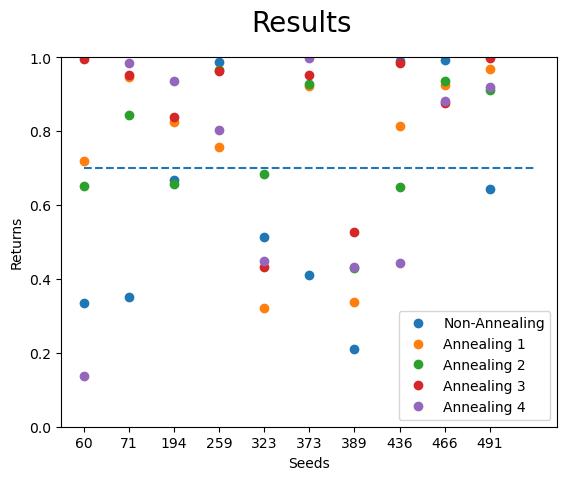

In [3]:
annealing_2 = []
# annealing 2
RA_sig_slope = 15
LEARNING_RATE_HL = 2e-5
for i in tqdm(range(TEST_NOS)):
    seed = seeds[i]
    returns = build_and_run(seed, True, True)
    annealing_2.append(returns)
print(f"RA_sig_slope = {RA_sig_slope}, LEARNING_RATE_HL = {LEARNING_RATE_HL}")
print(f"Annealing 2 = {annealing_2}")

# Plotting is done outside the file writing block to not capture plot generation messages
fig, ax = plt.subplots(1,1)
ax.plot(non_annealing_returns, label='Non-Annealing', linewidth=0, marker='o')
ax.plot(annealing_1, label='Annealing 1', linewidth=0, marker='o')
ax.plot(annealing_2, label='Annealing 2', linewidth=0, marker='o')
ax.plot(annealing_3, label='Annealing 3', linewidth=0, marker='o')
ax.plot(annealing_4, label='Annealing 4', linewidth=0, marker='o')
ax.set_ylim(0, 1)
plt.xticks(np.arange(0, TEST_NOS, step=1), labels=seeds)
ax.legend()
ax.set_xlabel('Seeds')
ax.set_ylabel('Returns')
plt.hlines(0.7, 0, TEST_NOS, linestyles='dashed')
fig.suptitle('Results', fontsize=20)
fig.size = (20, 20)
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

 Random seed is 60


 10%|█         | 1/10 [00:40<06:02, 40.26s/it]

 Random seed is 71


 20%|██        | 2/10 [01:25<05:43, 42.99s/it]

 Random seed is 194


 30%|███       | 3/10 [02:06<04:54, 42.05s/it]

 Random seed is 259


 40%|████      | 4/10 [02:49<04:16, 42.67s/it]

 Random seed is 323


 50%|█████     | 5/10 [03:32<03:33, 42.70s/it]

 Random seed is 373


 60%|██████    | 6/10 [04:19<02:57, 44.33s/it]

 Random seed is 389


 70%|███████   | 7/10 [05:04<02:13, 44.48s/it]

 Random seed is 436


 80%|████████  | 8/10 [05:52<01:30, 45.40s/it]

 Random seed is 466


 90%|█████████ | 9/10 [06:37<00:45, 45.32s/it]

 Random seed is 491


100%|██████████| 10/10 [07:23<00:00, 44.34s/it]


RA_sig_slope = 20, LEARNING_RATE_HL = 2e-05
Annealing 5 = [0.9809449236611134, 0.9580530643980417, 0.5827354173582403, 0.3345472777044078, 0.5272925027770916, 0.8960000160387005, 0.2998828305753707, 0.7873871300186879, 0.9864128717627395, 0.36942996146939466]


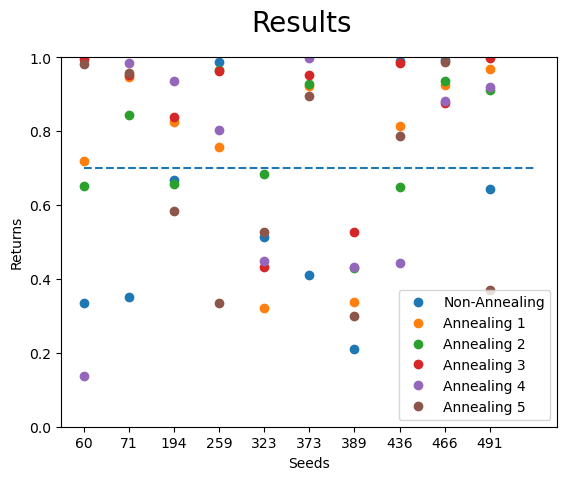

In [4]:
annealing_5 = []
# annealing 5
BG_sig_slope = 5  
RA_sig_slope = 20
LEARNING_RATE_HL = 2e-5
ANNEALING_SLOPE = 2 # 4
ANNEALING_MID = 5 # 2 
for i in tqdm(range(TEST_NOS)):
    seed = seeds[i]
    returns = build_and_run(seed, True, True)
    annealing_5.append(returns)
print(f"RA_sig_slope = {RA_sig_slope}, LEARNING_RATE_HL = {LEARNING_RATE_HL}")
print(f"Annealing 5 = {annealing_5}")

# Plotting is done outside the file writing block to not capture plot generation messages
fig, ax = plt.subplots(1,1)
ax.plot(non_annealing_returns, label='Non-Annealing', linewidth=0, marker='o')
ax.plot(annealing_1, label='Annealing 1', linewidth=0, marker='o')
ax.plot(annealing_2, label='Annealing 2', linewidth=0, marker='o')
ax.plot(annealing_3, label='Annealing 3', linewidth=0, marker='o')
ax.plot(annealing_4, label='Annealing 4', linewidth=0, marker='o')
ax.plot(annealing_5, label='Annealing 5', linewidth=0, marker='o')
ax.set_ylim(0, 1)
plt.xticks(np.arange(0, TEST_NOS, step=1), labels=seeds)
ax.legend()
ax.set_xlabel('Seeds')
ax.set_ylabel('Returns')
plt.hlines(0.7, 0, TEST_NOS, linestyles='dashed')
fig.suptitle('Results', fontsize=20)
fig.size = (20, 20)
plt.show()

In [8]:
annealing_3 = []
annealing_5 = []

seeds = np.random.randint(0, 500, TEST_NOS)
seeds = np.sort(seeds)
print("Seeds: ", seeds)

# annealing 5
BG_sig_slope = 5
RA_sig_slope = 20
LEARNING_RATE_HL = 2e-5
ANNEALING_SLOPE = 2 # 4
ANNEALING_MID = 5 # 2
for i in tqdm(range(TEST_NOS)):
    seed = seeds[i]
    returns = build_and_run(seed, True, True)
    annealing_5.append(returns)
print(f"RA_sig_slope = {RA_sig_slope}, LEARNING_RATE_HL = {LEARNING_RATE_HL}")
print(f"Annealing 5 = {annealing_5}")


# annealing 3
BG_sig_slope = 2.5
RA_sig_slope = 18
LEARNING_RATE_HL = 2e-5
ANNEALING_SLOPE = 4 # 4
ANNELING_MID = 2 # 2
for i in tqdm(range(TEST_NOS)):
    seed = seeds[i]
    returns = build_and_run(seed, True, True)
    annealing_3.append(returns)
print(f"RA_sig_slope = {RA_sig_slope}, LEARNING_RATE_HL = {LEARNING_RATE_HL}")
print(f"Annealing 3 = {annealing_3}")


Seeds:  [ 20  42  59  60  74 142 286 378 401 464]


  0%|          | 0/10 [00:00<?, ?it/s]

 Random seed is 20


 10%|█         | 1/10 [00:44<06:42, 44.78s/it]

 Random seed is 42


 20%|██        | 2/10 [01:32<06:11, 46.46s/it]

 Random seed is 59


 30%|███       | 3/10 [02:16<05:17, 45.41s/it]

 Random seed is 60


 40%|████      | 4/10 [03:05<04:41, 46.94s/it]

 Random seed is 74


 50%|█████     | 5/10 [03:53<03:55, 47.09s/it]

 Random seed is 142


 60%|██████    | 6/10 [04:40<03:09, 47.27s/it]

 Random seed is 286


 70%|███████   | 7/10 [05:29<02:23, 47.76s/it]

 Random seed is 378


 80%|████████  | 8/10 [06:22<01:38, 49.46s/it]

 Random seed is 401


 90%|█████████ | 9/10 [07:11<00:49, 49.26s/it]

 Random seed is 464


100%|██████████| 10/10 [08:01<00:00, 48.12s/it]


RA_sig_slope = 20, LEARNING_RATE_HL = 2e-05
Annealing 5 = [0.5068711500803347, 0.7982938253691834, 0.551993801622797, 0.9809449236611134, 0.9050561860589282, 0.7534309919079648, 0.9054419840874098, 0.4418078441763229, 0.8515977163747479, 0.9593855772919685]


  0%|          | 0/10 [00:00<?, ?it/s]

 Random seed is 20


 10%|█         | 1/10 [00:51<07:46, 51.84s/it]

 Random seed is 42


 20%|██        | 2/10 [01:45<07:03, 52.92s/it]

 Random seed is 59


 30%|███       | 3/10 [02:33<05:54, 50.66s/it]

 Random seed is 60


 40%|████      | 4/10 [03:20<04:55, 49.28s/it]

 Random seed is 74


 50%|█████     | 5/10 [04:08<04:03, 48.75s/it]

 Random seed is 142


 60%|██████    | 6/10 [05:04<03:24, 51.24s/it]

 Random seed is 286


 70%|███████   | 7/10 [06:07<02:44, 54.93s/it]

 Random seed is 378


 80%|████████  | 8/10 [07:09<01:54, 57.16s/it]

 Random seed is 401


 90%|█████████ | 9/10 [08:13<00:59, 59.36s/it]

 Random seed is 464


100%|██████████| 10/10 [09:13<00:00, 55.37s/it]

RA_sig_slope = 18, LEARNING_RATE_HL = 2e-05
Annealing 3 = [0.7923497316697343, 0.7766123948900091, 0.36654998834964564, 0.87960544564246, 0.5612212596695216, 0.3612951769936841, 0.6499018681246966, 0.26432192108531577, 0.4797804690760966, 0.5982936580281144]


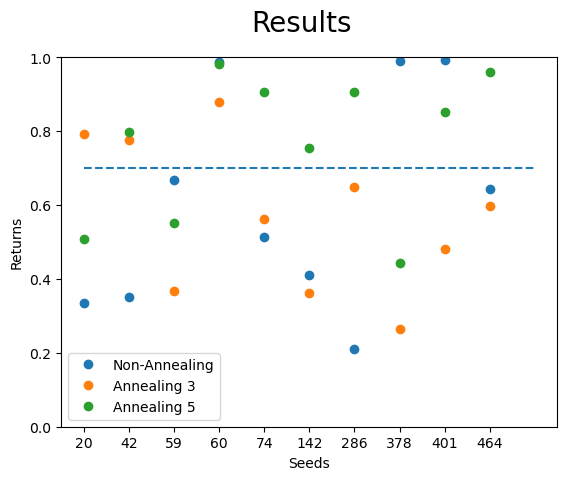

In [9]:

# Plotting is done outside the file writing block to not capture plot generation messages
fig, ax = plt.subplots(1,1)
ax.plot(non_annealing_returns, label='Non-Annealing', linewidth=0, marker='o')
ax.plot(annealing_3, label='Annealing 3', linewidth=0, marker='o')
ax.plot(annealing_5, label='Annealing 5', linewidth=0, marker='o')
ax.set_ylim(0, 1)
plt.xticks(np.arange(0, TEST_NOS, step=1), labels=seeds)
ax.legend()
ax.set_xlabel('Seeds')
ax.set_ylabel('Returns')
plt.hlines(0.7, 0, TEST_NOS, linestyles='dashed')
fig.suptitle('Results', fontsize=20)
fig.size = (20, 20)
plt.show()
